In [1]:
# ==== Librerías principales ====
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# ==== Comprobación de GPU ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)


Usando dispositivo: cuda


In [2]:
# ==== 1. Definir transformaciones ====
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],   # Media ImageNet
                             [0.229, 0.224, 0.225])  # Std ImageNet
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# ==== 2. Directorio base del dataset ====
data_dir = "dataset_dividido_v1"

# ==== 3. Cargar datasets ====
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}

# ==== 4. Cargar en DataLoader ====
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x=="train"), num_workers=2)
    for x in ["train", "val", "test"]
}

# ==== 5. Cargar mapping desde classes.txt ====
with open(os.path.join(data_dir, "classes.txt")) as f:
    classes = [line.strip() for line in f]

print("Clases detectadas:", classes)
print("Mapping interno de ImageFolder:", image_datasets["train"].class_to_idx)


Clases detectadas: ['Condones', 'Cajas de condones', 'Esponjas', 'Botellas de Cloro', 'Placas madre']
Mapping interno de ImageFolder: {'Botellas de Cloro': 0, 'Cajas de condones': 1, 'Condones': 2, 'Esponjas': 3, 'Placas madre': 4}


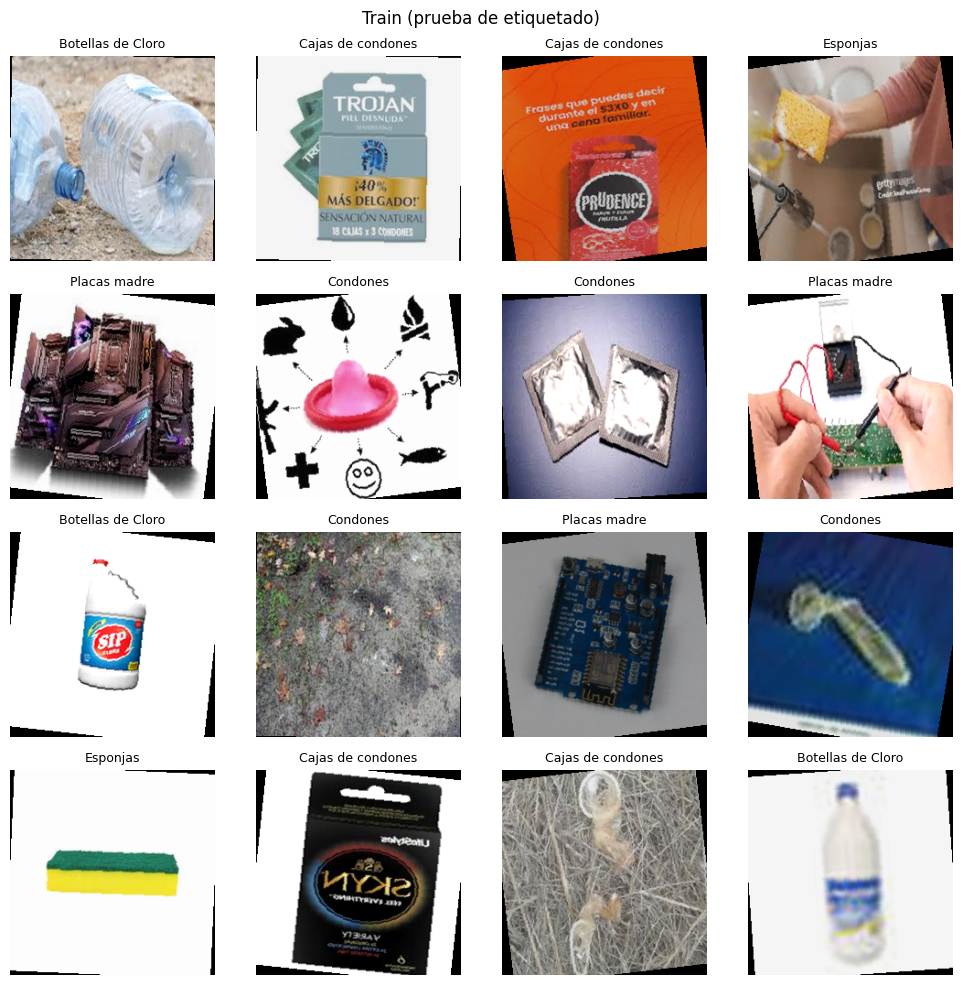

In [5]:
# ==== Visualización de ejemplos (train/val/test) ====
import itertools

# Stats usadas en la normalización (ImageNet)
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

# Mapeo idx->clase según ImageFolder
idx_to_class = {v: k for k, v in image_datasets["train"].class_to_idx.items()}

def denormalize(img_tensor):
    """Deshace la normalización para poder mostrar colores correctos."""
    return (img_tensor * IMAGENET_STD) + IMAGENET_MEAN

def show_batch(dataloader, n=16, title="Muestras"):
    """Muestra n imágenes (máx 64) del dataloader y sus etiquetas."""
    n = min(n, 64)
    imgs_shown = 0
    plt.figure(figsize=(10, 10))
    cols = 4
    rows = int(np.ceil(n / cols))

    for images, labels in dataloader:
        # Trabajar en CPU para plot
        images = images.cpu()
        labels = labels.cpu()

        for img, lab in zip(images, labels):
            if imgs_shown >= n:
                break
            imgs_shown += 1
            plt.subplot(rows, cols, imgs_shown)
            img_dn = denormalize(img).clamp(0, 1)  # [0,1]
            plt.imshow(np.transpose(img_dn.numpy(), (1, 2, 0)))
            plt.title(idx_to_class[int(lab)], fontsize=9)
            plt.axis("off")
        if imgs_shown >= n:
            break

    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# ---- Ejemplos rápidos ----
show_batch(dataloaders["train"], n=16, title="Train (prueba de etiquetado)")


In [ ]:
# ==== Modelo CNN desde cero ====
import math

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        chs = [3, 32, 64, 128, 256]  # canales por etapa
        self.stage1 = nn.Sequential(ConvBlock(chs[0], chs[1]), nn.MaxPool2d(2))
        self.stage2 = nn.Sequential(ConvBlock(chs[1], chs[2]), nn.MaxPool2d(2))
        self.stage3 = nn.Sequential(ConvBlock(chs[2], chs[3]), nn.MaxPool2d(2))
        self.stage4 = nn.Sequential(ConvBlock(chs[3], chs[4]), nn.MaxPool2d(2))
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(chs[4], num_classes)
        self._init_weights()

    def _init_weights(self):
        # Kaiming-He para capas conv; Linear con fan_out
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stage1(x)  # 112x112
        x = self.stage2(x)  # 56x56
        x = self.stage3(x)  # 28x28
        x = self.stage4(x)  # 14x14
        x = self.gap(x)     # BxCx1x1
        x = x.flatten(1)    # BxC
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = len(image_datasets["train"].classes)
model = SimpleCNN(num_classes=num_classes).to(device)

In [12]:
# ==== Entrenamiento: criterio, optimizador y scheduler ====
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 30
USE_AMP = True  # aprovecha CUDA con precision mixta si está disponible

# Scheduler (opción A: coseno)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.amp.GradScaler(enabled=USE_AMP and (device.type == "cuda"))

# Early stopping
best_val_loss = float("inf")
best_state = None
patience = 7
patience_counter = 0


In [8]:
# ==== Funciones de entrenamiento y validación ====
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss, total_acc, total_samples = 0.0, 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        with torch.cuda.amp.autocast(enabled=USE_AMP and (device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            # Clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        total_acc += accuracy_from_logits(outputs, labels) * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples
    return avg_loss, avg_acc


In [13]:
# ==== Loop principal de entrenamiento ====
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model, dataloaders["train"], optimizer=optimizer)
    val_loss, val_acc = run_epoch(model, dataloaders["val"], optimizer=None)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
          f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping activado.")
            break

# Restaurar mejor estado y guardar
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
torch.save(model.state_dict(), "best_cnn_from_scratch.pt")
print("Mejor modelo guardado en: best_cnn_from_scratch.pt")


C:\Users\jhean\AppData\Local\Temp\ipykernel_19256\1847263891.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP and (device.type == "cuda")):


[01/30] train_loss=1.0248 val_loss=0.9722 train_acc=0.6086 val_acc=0.6238
[02/30] train_loss=0.9483 val_loss=1.0479 train_acc=0.6371 val_acc=0.6520
[03/30] train_loss=0.8820 val_loss=0.9379 train_acc=0.6740 val_acc=0.6583
[04/30] train_loss=0.8379 val_loss=0.9299 train_acc=0.6828 val_acc=0.6426
[05/30] train_loss=0.7868 val_loss=0.8318 train_acc=0.7121 val_acc=0.7241
[06/30] train_loss=0.7530 val_loss=0.8371 train_acc=0.7214 val_acc=0.6991
[07/30] train_loss=0.7104 val_loss=0.7625 train_acc=0.7432 val_acc=0.7335
[08/30] train_loss=0.7025 val_loss=0.8073 train_acc=0.7456 val_acc=0.7179
[09/30] train_loss=0.6873 val_loss=0.7883 train_acc=0.7430 val_acc=0.7179
[10/30] train_loss=0.6555 val_loss=0.6660 train_acc=0.7643 val_acc=0.7837
[11/30] train_loss=0.6208 val_loss=0.7604 train_acc=0.7695 val_acc=0.7179
[12/30] train_loss=0.6156 val_loss=0.6839 train_acc=0.7833 val_acc=0.7461
[13/30] train_loss=0.6006 val_loss=0.6437 train_acc=0.7803 val_acc=0.7806
[14/30] train_loss=0.5661 val_loss=0.6

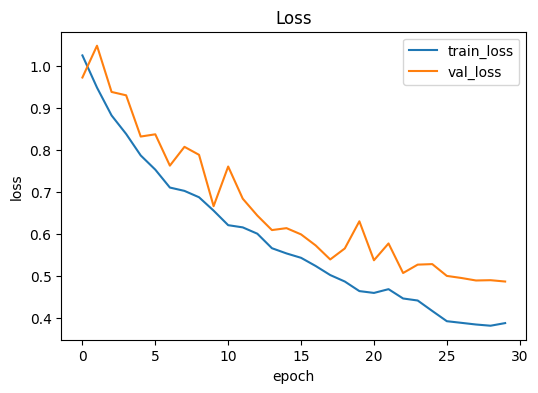

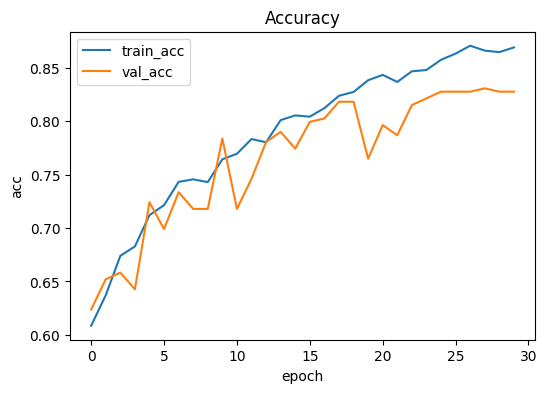

In [14]:
# ==== Curvas ====
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.show()


TEST Accuracy: 0.8401

== Classification report ==
                   precision    recall  f1-score   support

Botellas de Cloro     0.7973    0.9077    0.8489       195
Cajas de condones     0.8529    0.8140    0.8330       285
         Condones     0.7562    0.7516    0.7539       161
         Esponjas     0.9118    0.8267    0.8671       150
     Placas madre     0.9054    0.9116    0.9085       147

         accuracy                         0.8401       938
        macro avg     0.8447    0.8423    0.8423       938
     weighted avg     0.8424    0.8401    0.8400       938

Macro-F1: 0.8422912998041767


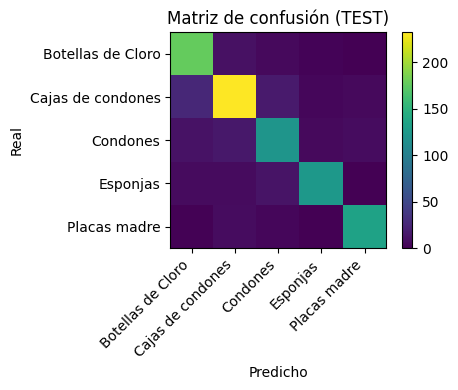

In [15]:
# ==== Evaluación completa en TEST ====
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images = images.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Accuracy simple
test_acc = (all_preds == all_labels).mean()
print(f"TEST Accuracy: {test_acc:.4f}")

# Reporte por clase (si sklearn disponible)
try:
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    print("\n== Classification report ==")
    print(classification_report(all_labels, all_preds, target_names=image_datasets["test"].classes, digits=4))
    print("Macro-F1:", f1_score(all_labels, all_preds, average="macro"))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Matriz de confusión (TEST)")
    plt.colorbar()
    tick_marks = np.arange(len(image_datasets["test"].classes))
    plt.xticks(tick_marks, image_datasets["test"].classes, rotation=45, ha="right")
    plt.yticks(tick_marks, image_datasets["test"].classes)
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("sklearn no disponible o error en métricas:", e)
    # Fallback: conteo simple
    num_classes = len(image_datasets["test"].classes)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(all_labels, all_preds):
        cm[t, p] += 1
    print("Matriz de confusión (simple):\n", cm)
